# Harmonic Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
# use to scale figure size
plt.rcParams['figure.dpi'] = 120

## Table of contents

1. [Introduction](#introduction)
2. [Fourier-Analysis](#fourier)
    1. [Mathematical groundwork](#fourier-mat)
    2. [CFT/DFT](#fourier-dft-cft)
    3. [Examples](#fourier-bsp)
    4. [Gridding](#fourier-grid)
    5. [FFT](#fourier-fft)
3. [Lomb-Scargle Periodograms](#period)
    1. [Mathematical groundwork](#period-mat)
    2. [Examples](#period-bsp)
4. [Fourier vs. Lomb-Scargle](#vergl)
5. [Outlook and Literature](#outlook)

## Introduction <a name="introduction"></a>

Some problems, which have been discussed so far in SMD, can be treated by means of harmonic analysis methods in addition to the methods already mentioned. These methods are particularly suitable for so-called time series, i.e. all data which have a time dimension in addition to their other attributes, and aim at obtaining information by decomposing the signals into harmonic components (sine and cosine functions) of different frequencies. 

An example would be the search for a radio signal in a noise background. Intrinsically, these methods are also suitable for periodic problems, for example measurements of exoplanets orbiting a central star. Two main methods are discussed below: The __Fourier analysis__ and the __Lomb-Scargle periodograms__.

## Fourier-Analysis <a name="fourier"></a>

### Mathematical groundwork <a name="fourier-mat"></a>

The Fourier series and the Fourier expansion were introduced by _Jean Baptiste Joseph Fourier_.
By the Fourier series 

$$
\begin{equation}
    \frac{c_0}{2} + \sum_{k = 1}^{\infty} (c_m \cos(mt) + s_m \sin(mt))
\end{equation}
$$

named after him almost every periodic function with the period length $T = 2\pi$ can be reproduced. The coefficients $c_m$ and $s_m$ have to be adapted to the function to be reproduced and are determined by

$$
\begin{aligned}
    c_m \,&=\,\frac{1}{\pi}\int_{-\pi}^{\pi}f(t)\,\cos(mx)\,dt \qquad m \in \mathbb{N_0}\\
    s_m \,&=\,\frac{1}{\pi}\int_{-\pi}^{\pi}f(t)\,\sin(mx)\,dt \qquad m \in \mathbb{N_0}.\\
\end{aligned}
$$

By using complex-valued coefficients, the Fourier decomposition can be formulated more handily

$$
\begin{equation}
f_{\rm IF}(t) \,=\, \sum_{m = -\infty}^{\infty}a_m \,e^{\mathrm{i} mt} \, .
\end{equation}
$$

The coefficients are given by

$$
\begin{equation}
a_m \,=\, \frac{1}{2\pi}\int_{-\pi}^{\pi}f(t)e^{-\mathrm{i} mt}\,dt\qquad \forall m\in\mathbb{Z} \, .
\end{equation}
$$

A substitution $t \rightarrow \frac{2\pi}{T} t$ extends the Fourier decomposition to functions of arbitrary periodicity, the integrals of the coefficients in this case are evaluated to $[-\frac{T}{2}, \, \frac{T}{2}]$. The terms $\frac{2\pi m}{T}$ arising in the expressions can be identified as angular frequencies $\omega_m$.
Fourier decomposition made it possible to solve historically unsolvable differential equations, and it provided the impetus for the study of the convergence of infinite series.

In the following, we perform a Fourier decomposition using a rectangular signal as an example. First the coefficients are defined in `fs_coeffs`, `fourier_coefficients` determines all desired coefficients from $-m$ to $m$ and the function `eval_fourier` forms the actual Fourier sum. After defining the rectangle function, the decomposition can be performed and plotted.

In [4]:
from functools import partial
from scipy.integrate import quad
# Define some functions to perfom a fourier decomposition

def fs_coeff(func, m, T):
    '''Calculate the mth fourier coeffiecient for func that has period T'''
    def integrand(t):
        return func(t) * np.exp(-1j * m * 2 * np.pi * t / T)

    def real(t):
        return np.real(integrand(t))
    
    def imaginary(t):
        return np.imag(integrand(t))
    
    real_int, _ = quad(real, -T/2, T/2)
    imag_int, _ = quad(imaginary, -T/2, T/2)
    
    return (real_int + 1j * imag_int) / T


def fourier_coefficients(func, max_m, T):
    '''Calculate -max_m ... max_m fourier coefficients'''
    return np.array([fs_coeff(func, m, T) for m in range(-max_m, max_m + 1)]) 


def eval_fourier(t, coefficients, T):
    '''Evaluate the fourier transformation given by coeffiecents at position t'''
    def fourier(am, m):
        return am * np.exp(2.0j * np.pi * m * t / T) 
    
    
    max_m = len(coefficients) // 2
    result = np.sum([fourier(am, m) for m, am in enumerate(coefficients, start=-max_m)], axis=0)
    
    return np.real_if_close(result)

def square_wave(x, T=2*np.pi):
    '''Define a square wave function'''
    return np.where(x % T > (0.5 * T), 0, 1)

<IPython.core.display.Javascript object>


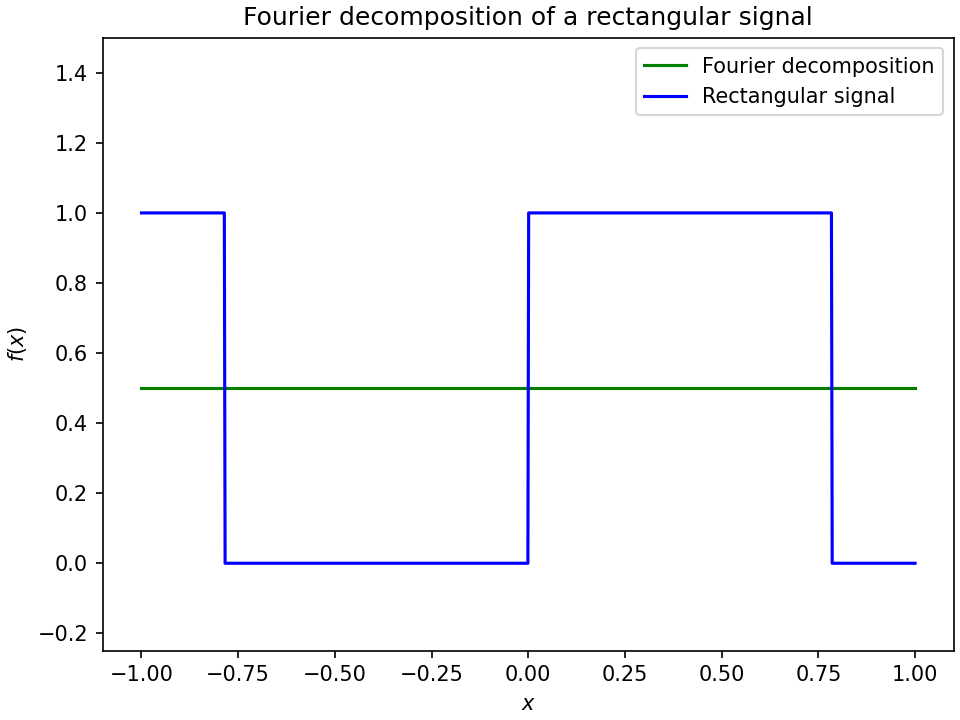

interactive(children=(IntSlider(value=0, description='m', max=20, step=2), FloatSlider(value=1.570796326794896…

<function __main__.plot_fourier(m=0, T=1.5707963267948966)>

In [5]:
from ipywidgets import interact
# Set domain and compute square wave
N = 1000
x = np.linspace(-1.0, 1.0, N)
T = np.pi / 2
f = partial(square_wave, T=T)
coeffs = fourier_coefficients(f, 0, T)


# Compute the FS up to order m

fig, ax = plt.subplots(constrained_layout=True)
line, = ax.plot(x, eval_fourier(x, coeffs, T), 'g', label=r'Fourier decomposition')
truth, = ax.plot(x, f(x), 'b', label=r'Rectangular signal')
ax.set_title(r"Fourier decomposition of a rectangular signal")
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f(x)$')
ax.legend()
ax.set_ylim(-0.25, 1.5)

def plot_fourier(m=0, T=T):
    f = partial(square_wave, T=T)
    coeffs = fourier_coefficients(f, m, T)
    truth.set_ydata(f(x))
    y = eval_fourier(x, coeffs, T)
    line.set_ydata(y)

interact(plot_fourier, m=(0, 20, 2), T=(np.pi/8, 2 * np.pi, 0.05))

### CFT/DFT <a name="fourier-dft-cft"></a>

###### Continuous Fourier Transformation
From the above introduced formulation of the Fourier series follows in the limiting case of infinite period lengths $T$ the Fourier integral 

$$
\begin{equation}
    f(t) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} \tilde{f}(\omega) \exp{(\mathrm{i} \omega t)} \mathrm{d}       \omega \, .
\end{equation}
$$

The Fourier coefficients result in 

$$
\begin{equation}
    \tilde{f}(\omega) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} f(t) \exp{-(\mathrm{i} \omega t)} \mathrm{d}t
\end{equation}
$$

and the inverse transformation can be calculated. This is the so-called *continuous Fourier transform (CDF)*. 

###### Discrete Fourier Transformation
In reality, the measurement of a continuous function is impossible, information is only available at $N$ discrete measurement times $t_k$, which are here necessarily equally spaced with the distance $\rm \Delta$. Accordingly, the $k$th measurement is taken at $t_k = k \rm \Delta$. Given this discrete measurement there is often an interest to get access to the information in the frequency space, thus a discretization of above integrals is needed. It should be noted that with discrete sampling of the signal to be measured, the measurable frequencies are limited. This is the central statement of the __Nyquist-Shannon sampling theorem__, the measurable frequencies are limited to $[-\omega_c, \, + \omega_c]$ with $\omega_c = \frac{\pi}{\rm \Delta}$, in between are equally distributed the $N+1$ measurable frequencies

$$
\begin{equation}
    \omega_n = 2\pi \frac{n}{N \rm \Delta} \text{ mit } n = -\frac{N}{2}\, \ldots \, + \frac{N}{2}.
\end{equation}
$$

Correspondingly the Fourier transform can be calculated only for the discrete frequencies $\omega_n$, so 

$$
\begin{equation}
    \tilde{f}_{\text{discrete}}(\omega_{n}) = \sum_{k=0}^{N-1} f_{\text{discrete}}(t_k) \exp{\left(2\pi\mathrm{i} \frac{kn}{N}\right)}
\end{equation}
$$

and 

$$
\begin{equation}
    f_{\text{discrete}}(t_k) = \frac{1}{N} \sum_{n=0}^{N-1} \tilde{f}_{\text{discrete}}(\omega_{n}) \exp{\left(-2\pi\mathrm{i} \frac{kn}{N}\right)}
\end{equation}
$$

follow. This is the *discrete Fourier transformation (DFT)*.

### Examples <a name="fourier-bsp"></a>

##### First a simple example: Sinusoidal functions

We consider 4 closely related functions
$$
\begin{aligned}
f(x) &= 2 \cos{(x)} \\
g(x) &= 2 \cos{(x + 0.5 \pi)} \\
h(x) &= \cos{(x)} \\
i(x) &= 2 \cos{(x)} + 3.\\
\end{aligned}
$$

To generate the Fourier transforms we use
```python
scipy.fft.fft,
```
and calculate the corresponding frequencies using
```python
scipy.fft.fftfreq .
```
The inverse transformation (not shown here) would be given by
```python
scipy.fft.ifft .
```
Note that the Fourier transform also maps real inputs to complex values, so we have access to amplitude and phase information.

For this test case, the 4 functions are each sampled equidistantly on a grid.

In [6]:
from scipy.fft import fft, fftfreq
# Constants
spacing = 0.1
w = 1.0
phi = np.pi/2
A = 2

# x-space
x = np.arange(0, 10*np.pi, spacing)

# y-values
y_0 = A*np.cos(w*x)
y_0_phase = A*np.cos(w*x+phi)
y_0_amplitude = 0.5*A*np.cos(w*x)
y_0_offset = 3+y_0

# fft transform
A_signal_fft_0 = fft(y_0)
A_signal_fft_0_phase = fft(y_0_phase)
A_signal_fft_0_amplitude = fft(y_0_amplitude)
A_signal_fft_0_offset = fft(y_0_offset)
frequencies = fftfreq(np.size(x), spacing)

###### Let us first consider the amplitudes

In [7]:
# Plotting functions for amplitude and phase

def plot_amplitude(x, y, style, label, xlim=(-5, 5), ylim=(-25, 1000)):
    plt.stem(x, y, style, label=label)
    plt.xlabel(r"Circular frequency")
    plt.ylabel("Amplitude / a.u.")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(loc='upper right')
    
def plot_phase(x, y, style, label, xlim=(-5, 5), ylim=(-np.pi/2 -0.1, np.pi/2 + 0.1)):
    plt.stem(x, y, style, label=label)
    plt.xlabel(r"Circular frequency")
    plt.ylabel("Phase")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2], [r"$-\frac{\pi}{2}$", r"$-\frac{\pi}{4}$", "0", 
                                                     r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
    plt.legend(loc='upper right')

<IPython.core.display.Javascript object>


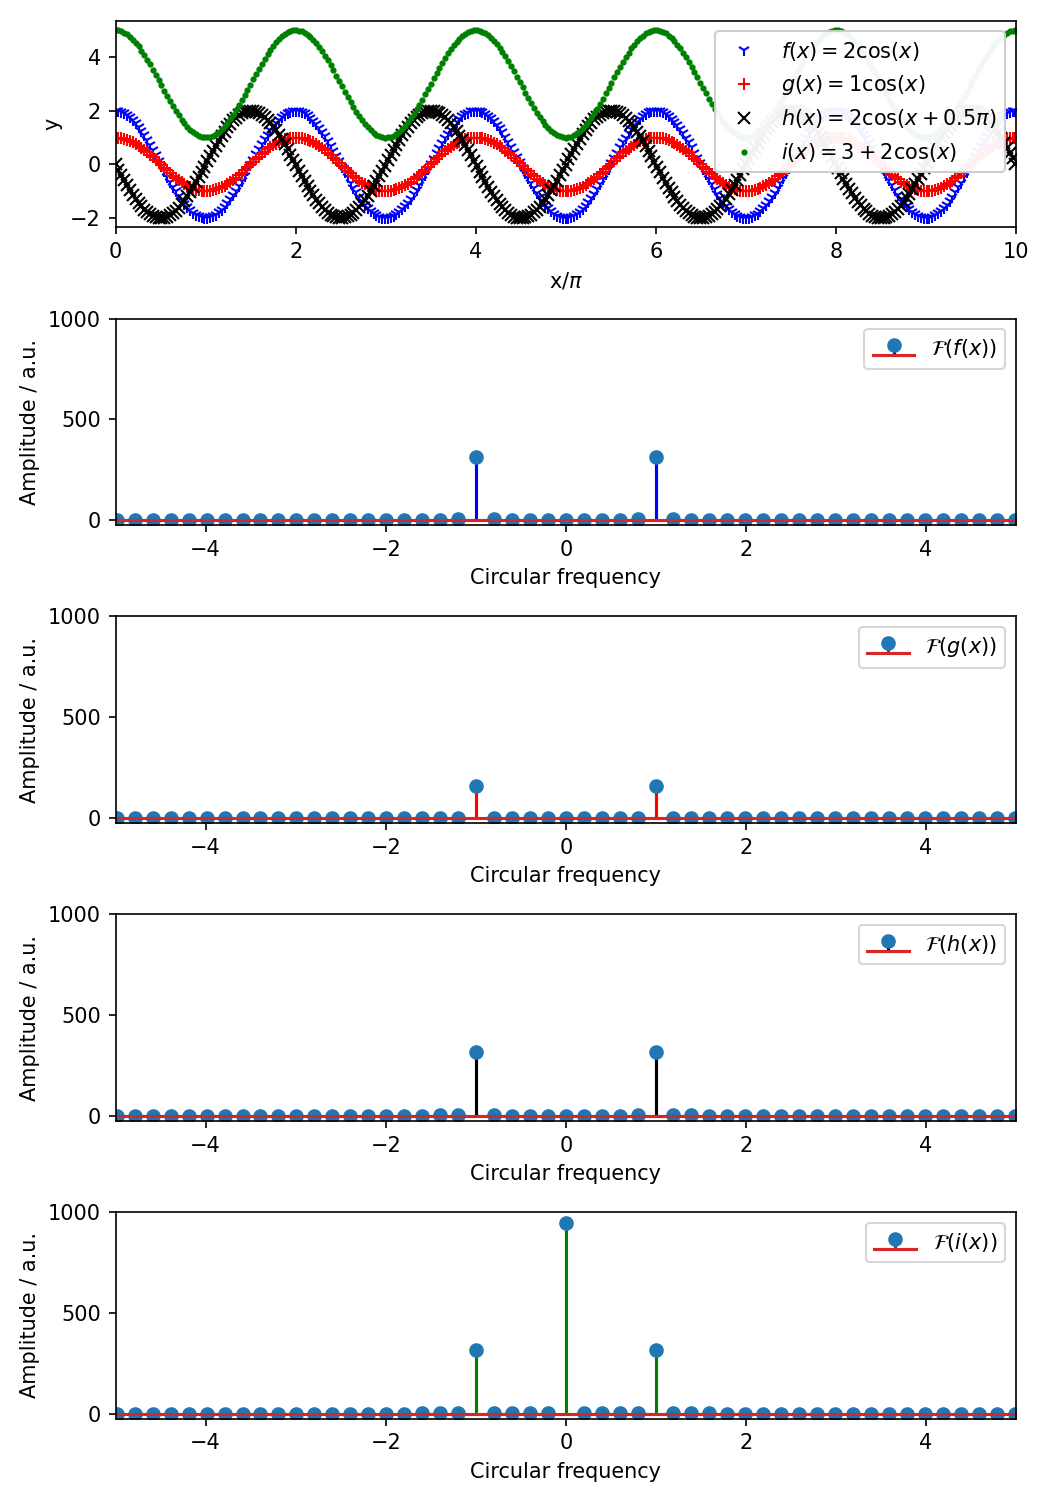

/tmp/ipykernel_395/1190331486.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)
/tmp/ipykernel_395/1190331486.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)
/tmp/ipykernel_395/1190331486.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)
/tmp/ipykernel_395/1190331486.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)


In [9]:
# Plot the amplitude spektrum
fig = plt.figure(figsize=(7, 10))
plt.subplot(5, 1, 1)
plt.plot(x/np.pi, y_0, 'b1', label=r'$f(x) = 2 \cos(x)$')
plt.plot(x/np.pi, y_0_amplitude, 'r+', label=r'$g(x) = 1 \cos(x)$')
plt.plot(x/np.pi, y_0_phase, 'kx', label=r'$h(x) = 2 \cos(x + 0.5 \pi)$')
plt.plot(x/np.pi, y_0_offset, 'go', ms=2, label=r'$i(x) = 3 + 2 \cos(x)$')
plt.xlabel(r"x/$\pi$")
plt.ylabel("y")
plt.xlim(0, 10)
plt.legend(loc='upper right', framealpha=0.95)

plt.subplot(5, 1, 2)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_fft_0), style='b-', label=r'$\mathcal{F}(f(x))$')

plt.subplot(5, 1, 3)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_fft_0_amplitude), 'r-', label=r'$\mathcal{F}(g(x))$')

plt.subplot(5, 1, 4)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_fft_0_phase), 'k-', label=r'$\mathcal{F}(h(x))$')

plt.subplot(5, 1, 5)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_fft_0_offset), 'g-', label=r'$\mathcal{F}(i(x))$')

fig.tight_layout(pad=1)
plt.show()
None

The important points are:
1. the amplitudes are mirror-symmetric around $y=0$.
2. the scaling of the $y$-axis does not correspond to the original amplitudes (compare $f(x)$ and $g(x)$).
3. the half amplitude of $g(x)$ leads to the half amplitude also in this representation (compare $f(x)$, $h(x)$ and $i(x)$).
4. introducing a constant term here provides, as expected, a contribution at a frequency of 0 (see $i(x)$).

Obviously, the Fourier transform here provides redundant (mirrored) information. These can simply be truncated in the present case. When using  
```python
scipy.fft.rfft
```
and 
```python
scipy.fft.rfftfreq,
```
these would not be compute at all. __Please note__: We can only use these versions since we transform real input data! This is not possible with complex input data.

###### Let us now look at the phase information

<IPython.core.display.Javascript object>


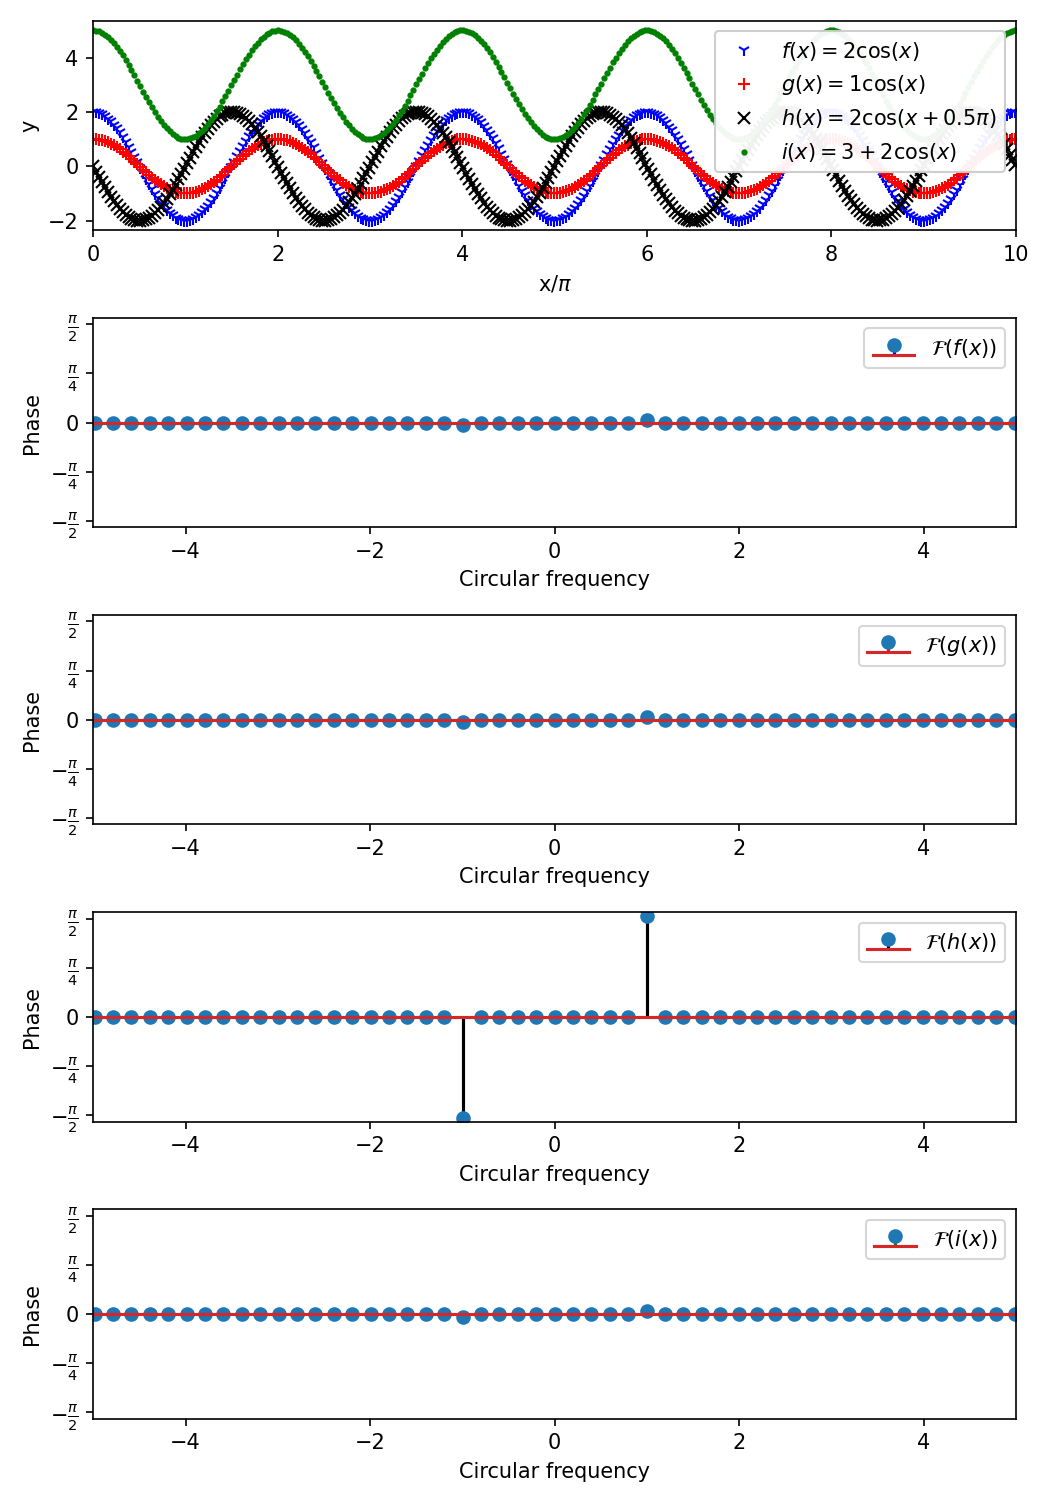

/tmp/ipykernel_395/1190331486.py:12: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)
/tmp/ipykernel_395/1190331486.py:12: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)
/tmp/ipykernel_395/1190331486.py:12: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)
/tmp/ipykernel_395/1190331486.py:12: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)


In [10]:
# Filter small components that arise due to the finite sampling  
A_signal_fft_0_phase[np.abs(A_signal_fft_0_phase) < 10] = 0
A_signal_fft_0_amplitude[np.abs(A_signal_fft_0_amplitude) < 10] = 0
A_signal_fft_0[np.abs(A_signal_fft_0) < 10] = 0
A_signal_fft_0_offset[np.abs(A_signal_fft_0_offset) < 10] = 0

# Plot the phases theta = arctan2(imag, real)
fig = plt.figure(figsize=(7, 10))
plt.subplot(5, 1, 1)
plt.plot(x/np.pi, y_0, 'b1', label=r'$f(x) = 2 \cos(x)$')
plt.plot(x/np.pi, y_0_amplitude, 'r+', label=r'$g(x) = 1 \cos(x)$')
plt.plot(x/np.pi, y_0_phase, 'kx', label=r'$h(x) = 2 \cos(x + 0.5 \pi)$')
plt.plot(x/np.pi, y_0_offset, 'go', ms=2, label=r'$i(x) = 3 + 2 \cos(x)$')
plt.xlabel(r"x/$\pi$")
plt.ylabel("y")
plt.xlim(0, 10)
plt.legend(loc='upper right', framealpha=0.95)

plt.subplot(5, 1, 2)
plot_phase(frequencies*2*np.pi, np.arctan2(A_signal_fft_0.imag, A_signal_fft_0.real), 'b-', 
           label=r'$\mathcal{F}(f(x))$')

plt.subplot(5, 1, 3)
plot_phase(frequencies*2*np.pi, np.arctan2(A_signal_fft_0_amplitude.imag, A_signal_fft_0_amplitude.real), 
         'r-', label=r'$\mathcal{F}(g(x))$')

plt.subplot(5, 1, 4)
plot_phase(frequencies*2*np.pi, np.arctan2(A_signal_fft_0_phase.imag, A_signal_fft_0_phase.real),
         'k-', label=r'$\mathcal{F}(h(x))$')

plt.subplot(5, 1, 5)
plot_phase(frequencies*2*np.pi, np.arctan2(A_signal_fft_0_offset.imag, A_signal_fft_0_offset.real),
         'g-', label=r'$\mathcal{F}(i(x))$')

fig.tight_layout(pad=1)
plt.show()

Again, we see what we expect: 
1. the only function with phase shift, $h(x)$, shows the desired phase of $0.5\pi$. 
2. the other functions also show (non-significant) phases at the oscillation frequency. 
3. the phase information shows a point-symmetry. 

The phase contributions of the functions without phase are caused by numerical effects due to the finite information available by the limited sampling. As for the point symmetry the same applies as above, they can be ignored.

###### Now a real example: sunspots.
We use the SILSO 13 Month smoothed monthly sunspot dataset https://wwwbis.sidc.be/silso/datafiles.

Columns of the dataset:
* Columns 1-2: Gregorian date
 * Year
 * Month
* Columns 3: Decimal date
* Columns 4: Smoothed number of sunspots per month.
* Columns 5: Standard deviation of sunspot number.
* Columns 6: Number of individual observations used to determine sunspot number.
* Columns 7: Definitive/provisional indicator. '1' indicates that the data are validated. '0' indicates provisional data.

In [11]:
# Coloum names
column_names = ['Greg_Year', 'Month', 'Dec_Year', 'N_total_sunspots_smoothed', 
                'Montly_mean_sunspot_number_std', 'N_obs', 'Marker']

# Input
sunspots = pd.read_csv('data/SN_ms_tot_V2.0.csv', names=column_names, sep=';')
sunspots = sunspots[sunspots['N_total_sunspots_smoothed'] >= 0]
sunspots.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/SN_ms_tot_V2.0.csv'

In [ ]:
# Inspect data
sunspots.dtypes

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(sunspots['Dec_Year'], sunspots['N_total_sunspots_smoothed'], 'k-')
plt.xlabel('Date')
plt.ylabel('Number of sunspots')
plt.title('Monthly averaged number of sunspots - time series')
None

A rough look at the data already shows interesting properties:

1. there is a periodicity with a period duration of about 10 years.
2. between 1800 and 1825 there was a strong minimum in the solar activity.
3. around 1950 there was a maximum in the solar activity.

Of course there are studies about this. The periodicity has been determined to be 11 years (see, for example, [this](https://iopscience.iop.org/article/10.1143/JJAP.33.2821) publication, which takes a slightly different approach to time series analysis). The minimum between 1800 and 1825, the so-called Dalton minimum, falls in the period of the Little Ice Age. At the peak of this climatological period is the better known Mounder minimum (not present in the data). The little ice age was artistically processed for example by the Dutch painter Hendrick Avercamp in his painting IJsvermaak ("ice pleasure"). However, it is **not** to be assumed that the minima of the solar activity are the sole cause of this epoch, they have intensified it at best.

![The painting IJsvermaak („ice pleasure“) by Hendrick Avercamp](Images/ijsvermaak.jpeg "The painting IJsvermaak („ice pleasure“) by Hendrick Avercamp")

With the increased solar activity between 1900 and 2000 one speaks of the so-called modern maximum, there is the possibility that this changes currently again into a minimum.

##### But now to the analysis of the data 
The data are already recorded on an (approximately) equidistant grid and are available in a frequency of 12 measurements per year. Furthermore, the data are described by real numbers, we can therefore directly use
```python
scipy.fft.rfft
```
und 
```python
scipy.fft.rfftfreq .
```

In [12]:
from scipy.fft import rfftfreq, rfft

# Fourier transform
A_signal_fft = rfft(sunspots['N_total_sunspots_smoothed'].to_numpy())
frequencies = rfftfreq(np.size(sunspots['Dec_Year'].to_numpy()), 1/12)

# Plotting
fig=plt.figure(figsize=(7, 4))
plt.clf()
plt.plot(frequencies, np.abs(A_signal_fft), lw=1.0, c='paleturquoise')
plt.stem(frequencies, np.abs(A_signal_fft), label=r"$|\mathcal{F}(N_{\mathrm{signal}})|$")
plt.xlabel(r"Frequency / a$^{-1}$")
plt.ylabel("Amplitude / a.u.")
plt.xlim(-0.01, 1)
plt.axvline(1/11, 0, 1, label=r'$T\,=\,11\,$a', color='black')
plt.legend(loc='best')
plt.title("Monthly averaged number of sunspots - time series")
None

NameError: name 'sunspots' is not defined

Two components stand out in particular:
1. $f = 0$: The constant term of the Fourier series resulting from the offset of the data along the $y$ axis.
2. $f \approx \frac{1}{11} \, \mathrm{a}^{-1}$: The 11-year periodicity of sunspots.

In the frequency domain, we can now perform filter operations to e.g. smooth the data. As an example we will use a low-pass filter here, so we set all frequency components above a (here arbitrarily chosen) cutoff frequency of $0.2 \, \mathrm{a}^{-1}$ to 0. In reality, one would make the transition between filtered and passed domain much less steep. There are, of course, other possibilities, e.g., high-pass and band-pass filters but also much more advanced approaches that are more selective on the frequency space.

For the retransformation we use 
```python
scipy.fft.irfft.
```

In [13]:
from scipy.fft import irfft

# Copy Amplitudes
A_signal_fft_filtered = A_signal_fft

# Set Amplitudes above 0.2 per year to 0
A_signal_fft_filtered[frequencies>0.2] = 0

# Inverse FFT to re-gain sonspot number per month
A_signal_filtered = irfft(A_signal_fft_filtered, len(sunspots['Dec_Year'].to_numpy()))

# Plot
plt.figure(figsize=(7, 4))
plt.plot(sunspots['Dec_Year'], sunspots['N_total_sunspots_smoothed'], 'r--', lw=1, label='Originale Daten')
plt.plot(sunspots['Dec_Year'], A_signal_filtered, 'k-', label='Geglättete Daten')
plt.xlabel('Date')
plt.ylabel('Number of sunspots')
plt.title('Monthly averaged number of sunspots - time series')
plt.legend(loc='best')
None

NameError: name 'A_signal_fft' is not defined

### Gridding <a name="fourier-grid"></a>

As discussed, one requirement for the feasibility of a DFT is the uniform sampling of the function to be transformed. But what to do if the measured values do not allow this? Such a problem occurs intrinsically e.g. in the field of radio astronomy but also in magnetic resonance imaging (which - mathematically - are closely related), but also simply non-uniformly taken measured values require an appropriate procedure. A solution to this problem lies in the use of so-called gridding operations.

Gridding is a very problematic but nevertheless necessary idea. Basically, what happens is this: $f(t)$, the discrete but non-uniformly and with $S(t)$ sampled function, is transformed in a first step by reweighting with $C(t)$ back into a continuous function, which is then evaluated according to a uniform sampling. This can be formulated mathematically. A uniform sampling can be described by a so-called Dirac comb 

$$
\begin{equation}
    III_{\rm \Delta}(t) = \sum_{n \in \mathbf{Z}}^{}  \delta{t + n\rm \Delta} \, .
\end{equation}
$$

The time limit of the measurement can be represented by the boxcar function $\Pi$

$$
\begin{equation}
    \begin{split}
        \Pi_{t_0,t_1}(t)
                       =\,\left \{
                       \begin{array}{lll}
                        0 & {\rm für} & x < t_0 \\
                        1 & {\rm für} & t_0 \le t \le t_1 \\ 
                        0 & {\rm für} & t > t_1 \, .\\
                       \end{array} \right. \end{split}
\end{equation}
$$

With these definitions we have for our gridded values

$$
\begin{equation}
    \hat{f}(t) = [[f(t) S(t)] * C(t)]III_{\rm \Delta}(t)\Pi_{t_0,t_1}(t),
\end{equation}
$$

where $g*h$ describes a convolution.

The core of this is a continuous function. Using the CDF $III(t)$ and $\Pi(t)$ transform the convolution integral into a sum in such a way that we arrive again at the definition of the DFT, finally the DFT of a convolution of two functions is calculated. According to the convolution theorem we get as a result the multiplication of the sought Fourier transformed values of the initial function multiplied by the undesired Fourier transformed values of the weighting function. Although there are strategies to deal with this problem, gridding should be avoided wherever it can be avoided.

###### Here is an example

Let us determine $C(t)$ such that linear interpolation is performed between the nearest neighbors of the non-uniformly sampled data. Let the non-uniform sampling be modeled by random measurement time points. Let the measured function be

$$
\begin{equation}
    f(x) = \sin{\left(x + \frac{\pi}{2} \right)}.
\end{equation}
$$

In [14]:
from scipy.stats import uniform
from scipy.interpolate import interp1d

# Original Sampling points
np.random.seed(1337)
sampling_points = np.sort(np.append(uniform(0, 10*np.pi).rvs(size=58), [0, 10*np.pi]))
sampled_function = np.sin(sampling_points + np.pi/2)

# Resampling function
def resampled_fuction(x, x_orig, y_orig):
    interp = interp1d(x_orig, y_orig)
    return interp(x)

# New equidistant sampling points
gridded_x = np.linspace(0.1, 9.9*np.pi, 60)
gridded_y = resampled_fuction(gridded_x, sampling_points, sampled_function)

# Data that is sampled equidistant from the beginning
equidistant_y = np.sin(gridded_x + np.pi/2)

# FFT
A_signal_gridded = rfft(gridded_y)
A_signal_equidistant = rfft(equidistant_y)
frequencies = rfftfreq(np.size(gridded_x), np.diff(gridded_x)[0])

<IPython.core.display.Javascript object>


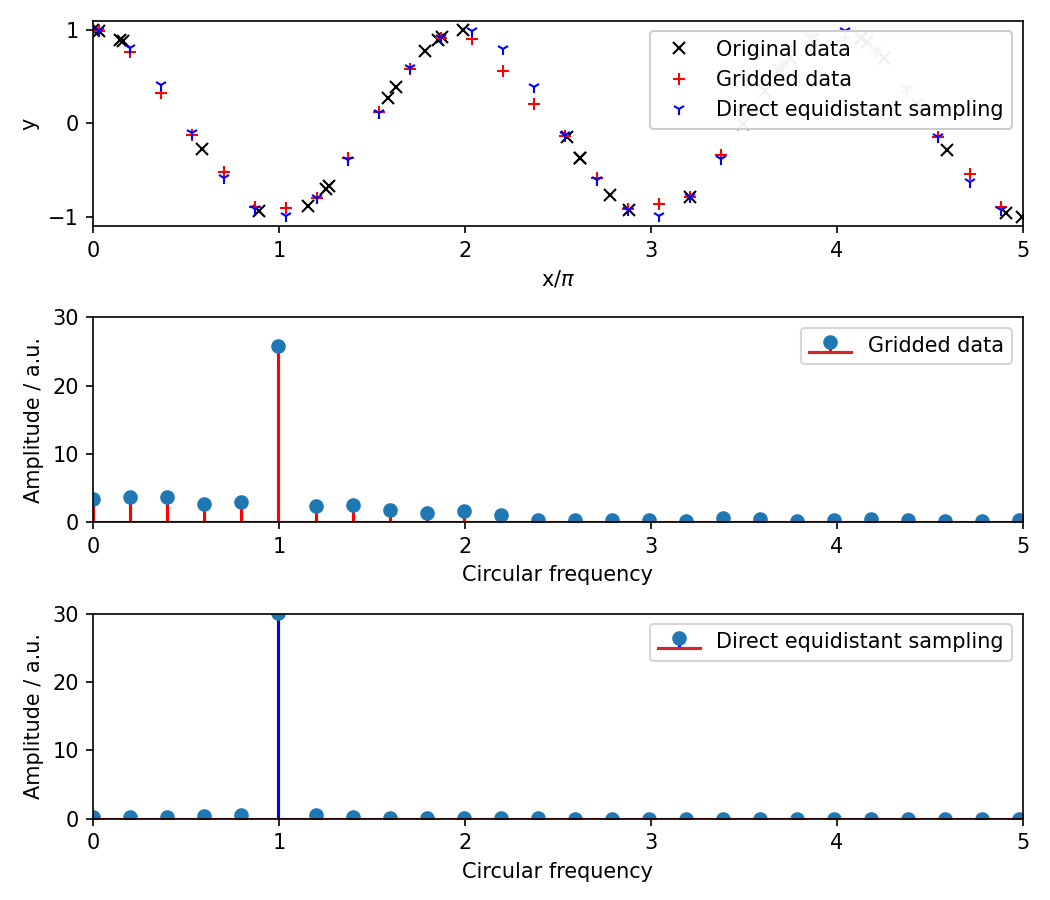

/tmp/ipykernel_395/1190331486.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)
/tmp/ipykernel_395/1190331486.py:4: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(x, y, style, label=label)


In [15]:
# Plotting
fig = plt.figure(figsize=(7, 6))
plt.subplot(3, 1, 1)
plt.plot(sampling_points/np.pi, sampled_function, 'kx', label='Original data')
plt.plot(gridded_x/np.pi, gridded_y, 'r+', label='Gridded data')
plt.plot(gridded_x/np.pi, equidistant_y, 'b1', label='Direct equidistant sampling')
plt.xlabel(r"x/$\pi$")
plt.ylabel("y")
plt.xlim(0, 5)
plt.legend(loc='upper right', framealpha=0.95)

plt.subplot(3, 1, 2)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_gridded), 'r-', 
               label='Gridded data', xlim=(0, 5), ylim=(0, 30))

plt.subplot(3, 1, 3)
plot_amplitude(frequencies*2*np.pi, np.abs(A_signal_equidistant), 'b-', 
         label='Direct equidistant sampling', xlim=(0, 5), ylim=(0, 30))
fig.tight_layout(pad=1)

By gridding we get in this case frequency components which are not present in the data and would not be present if we had measured the data equidistantly. The actually correct Fourier spectrum is smeared out.

### FFT <a name="fourier-fft"></a>

>The FFT is one of the truly great computational developments of
>this [20th] century. It has changed the face of science and
>engineering so much that it is not an exaggeration to say that life
>as we know it would be very different without the FFT.  
>*Charles van Loan, Computational Frameworks of the FFT, 1992*

>The Fast Fourier Transform—the most valuable numerical algorithm in our lifetime.  
*Gil Strang, Introduction to Linear Algebra, 2003*

>FFT voted one of the top 10 algorithms of the 20th century.  
*IEEE Computing in Science & Engineering, 1-2/2000*

The DFT introduced above is extremely run-time intensive with a running time $\mathcal{O}(N^2)$, the *Fast Fourier Transform (FFT)* algorithm first introduced in 1964 by Cooley and Tukey in their paper __An Algorithm for the Machine Calculation of Complex Fourier Series, Math. Comput. 19: 297-301__ allows calculation much faster, with a running time of $\mathcal{O}(N \log_{2}{(N)})$.

For implementation, the DFT is split into two sums each over the even and the odd indices

$$
\begin{aligned}
    \tilde{f}_{\text{discrete}}(\omega_{n}) = 
    \sum_{k=0}^{N-1} f_{\text{discrete}}(t_k) \exp{\left(2\pi\mathrm{i} \frac{kn}{N}\right)} &= 
    \sum_{k=0}^{\frac{N}{2}-1} f_{\text{discrete}}(t_{2k}) \exp{\left(2\pi\mathrm{i} \frac{2kn}{N}\right)} +
    \sum_{k=0}^{\frac{N}{2}-1} f_{\text{discrete}}(t_{2k+1}) \exp{\left(2\pi\mathrm{i} \frac{(2k+1)n}{N}\right)}\\ &=
    \sum_{k=0}^{\frac{N}{2}-1} f_{\text{discrete}}(t_{2k}) \exp{\left(2\pi\mathrm{i} \frac{kn}{N/2}\right)} +
    \exp{\left(\frac{2\pi\mathrm{i}n}{N}\right)} \sum_{k=0}^{\frac{N}{2}-1} f_{\text{discrete}}(t_{2k+1}) \exp{\left(2\pi\mathrm{i} \frac{kn}{N/2}\right)}\\ &=
    \tilde{f}\,_{\text{discrete}}^{\text{even}}(\omega_{n}) + W^{n} \cdot \tilde{f}\,_{\text{discrete}}^{\text{odd}}(\omega_{n})
\end{aligned}
$$

The even and odd parts of $\tilde{f}_{\text{discrete}}(\omega_{n})$ can each be calculated in $\left( \frac{N}{2} \right)^{2}$, the $W^{n}$ in $N$ operations. So, in sum, $2\left( \frac{N}{2} \right)^{2} + N$ operations are still needed. If now $N=2^{m}$ this division can be iteratively repeated $m-1$ times, the running time decreases to $\mathcal{O}(N \log_{2}{(N)})$. This leads for e.g. $N = 2^4 = 16$ to  256 (DFT) vs. 64 (FFT) operations, thus the FFT runs only a quarter of the time of the corresponding DFT.

The presented procedure is a so-called *divide and conquer* procedure (these procedures always have a logarithmic runtime dependence). The obvious disadvantage of this implemetation is that $N$ must now be a power of 2. Nevertheless, the runtime difference is so enormous that FFT algorithms are used almost exclusively and the data are padded if necessary until this prerequisite is fulfilled.

There are further approaches or alternatives to the formulation of a FFT, among other things by the division into more than 2 sums (e.g. Radix-4 and Radix-8), completely different divisions (Winograd algorithm) or by reformulation of the DFT as convolution (e.g. the Bluestein algorithm).

In [ ]:
m = np.arange(0, 21, 1)
N = 2**m

plt.figure(figsize=(7, 4))
plt.clf()
plt.yscale('log')
plt.plot(m, N**2, 'kx', label='DFT')
plt.plot(m, N*np.log(N), 'r+', label='FFT')
plt.xticks([0, 5, 10, 15, 20], ["0", "5", "10", "15", "20"])

plt.xlabel(r'log$_{2}(N)$')
plt.ylabel(r'$N_{\mathrm{Operations}}$')
plt.grid()
plt.title("Runtime comparison DFT/FFT")
plt.legend(loc='best')
None

## Lomb-Scargle periodograms <a name="period"></a>

### Mathematical groundwork <a name="period-mat"></a>

The following remarks are mainly taken from: **J.D. Scargle “Studies in astronomical time series analysis. II - Statistical aspects of spectral analysis of unevenly spaced data”, The Astrophysical Journal, vol 263, pp. 835-853, 1982.**

The simplest version of a periodogram is defined as

\begin{equation}
    P_X(\omega) = \frac{1}{N_0} \left|\mathrm{FT}_X(\omega) \right|^2 \quad \text{with} \ \mathrm{FT}_X(\omega) = \sum_{j=1}^{N_0} X(t_j) \exp(-i \omega t_j) \, .
\end{equation}

Inserting and utilizing the Euler relation leads to

\begin{align}
P_X(\omega) &= \frac{1}{N_0} \left| \sum_{j=1}^{N_0} X(t_j) \exp(-i \omega t_j) \right|^2 \\
&= \frac{1}{N_0} \left[ \left(\sum_j X_j \cos(\omega t_j) \right)^2 + \left(\sum_j X_j \sin(\omega t_j) \right)^2 \right] \, .
\end{align}

For equidistant sampling times with an interval of $\mathrm{\Delta}t$ follows

\begin{equation}
    P_X(\omega) = \frac{1}{N_0} \left|\sum^{N_0}_{j=1} X_j \exp(-ij\omega) \right|^2 \, ,
\end{equation}

if $\mathrm{\Delta t} = 1$, $t_j = j$ and $X_j = X(t_j)$ is chosen. The above formula can be evaluated very quickly with the frequencies $\omega_n = 2 \pi n/T$ $(n = -N_0/2, ..., +N_0/2)$ using the Fast Fourier Transform (FFT).

Due to two problems (statistical difficulties with noise and "spectral leakage"), Jeffrey D. Scargle developed an improved version of the periodogram in 1982:

\begin{equation}
     P_X(\omega) = \frac{1}{2} \left \{\frac{\left[\sum_{j}X_j \cos(\omega(t_j - \tau) \right]^2}{\sum^N_{j=1} \cos^2(\omega(t_j - \tau))} + \frac{\left[\sum_{j}X_j \sin(\omega(t_j - \tau) \right]^2}{\sum^N_{j=1} \sin^2(\omega(t_j - \tau))} \right \} \, ,
\end{equation}

where $\tau$ is defined as

\begin{equation}
    \tan(2 \omega \tau) = \frac{\sum_j \sin(2 \omega t_j)}{\sum_j \cos(2 \omega t_j)} \, .
\end{equation}

The Lomb-Scargle periodogram for $m$ frequencies is identical to the $m$ goodness-of-fit statistics that can be constructed when $m$ sinusodial functions (with $m$ frequencies) are fitted to the measured values by least-squares.

### Examples <a name="period-bsp"></a>

##### Again a simple example: Sinusoidal functions

To show the subtleties of the periodogram we use 3 closely related functions here:

$$
\begin{aligned}
f(x) &= 2 \cos{(x)} \\
g(x) &= 2 \cos{(x + 0.5 \pi)} \\
h(x) &= 2 \cos{(x)} + 3 \\
\end{aligned}
$$

The periodograms are computed using
```python
scipy.signal.lombscargle
```
It should be noted that the periodogram operates on circular frequencies.

In [16]:
from scipy.signal import lombscargle

# Define some constants
A = 2.0
w = 1.0
phi = 0.5 * np.pi
n_in = 1000
n_frequencies = 100000
frac_points = 0.25  # 1-Fraction of points to select as "measured"

# Get the x-positions
rng = np.random.default_rng()
r = rng.uniform(size=n_in)
x = np.linspace(0.01, 10*np.pi, n_in)
x = x[r < frac_points] # Randomly select measured points by rejection

# Get the frequencies for which the periodogram should be evaluated
f = np.linspace(0.01, 10, n_frequencies)

# Get y-values
y_0 = A * np.cos(w*x) # centered around 0
y_0_phase = A * np.cos(w*x+phi) # centered around 0 but with different phase
y_0_offset = y_0 + 3 # offset of 3

# Compute Periodograms
pgram_0 = lombscargle(x, y_0, f, normalize=True) # Periodogram for A cos(x+0.5)
pgram_0_phase = lombscargle(x, y_0_phase, f, normalize=True) # Periodogram for A cos(x+0.25)
pgram_offset = lombscargle(x, y_0_offset, f, normalize=True) # Periodogram for A cos(x+0.5) + 3
pgram_corr = lombscargle(x, y_0_offset-np.mean(y_0_offset), f, normalize=True) 
# Periodogram for A sin(x+0.5) + 3 - E(A sin(x+0.5) + 3)

<IPython.core.display.Javascript object>


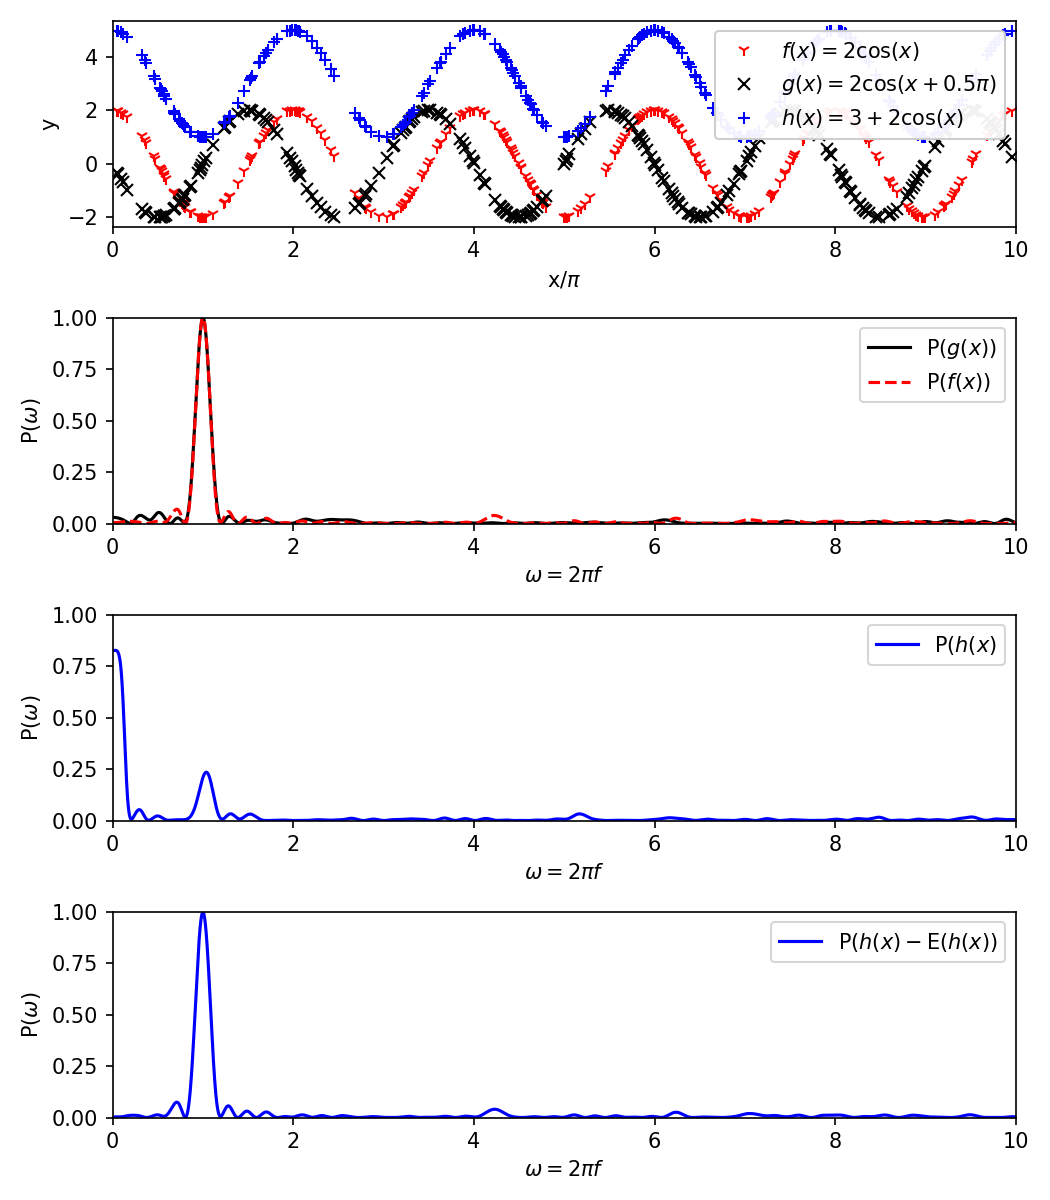

In [17]:
# Plotting
fig = plt.figure(figsize=(7, 8))
plt.subplot(4, 1, 1)
plt.plot(x/np.pi, y_0, 'r1', label=r'$f(x) = 2 \cos(x)$')
plt.plot(x/np.pi, y_0_phase, 'kx', label=r'$g(x) = 2 \cos(x + 0.5 \pi)$')
plt.plot(x/np.pi, y_0_offset, 'b+', label=r'$h(x) = 3 + 2 \cos(x)$')
plt.xlabel(r"x/$\pi$")
plt.ylabel("y")
plt.xlim(0, 10)
plt.legend(loc='upper right', framealpha=0.95)

plt.subplot(4, 1, 2)
plt.plot(f, pgram_0_phase, 'k', label=r'$\mathrm{P}(g(x))$')
plt.plot(f, pgram_0, 'r--', label=r'$\mathrm{P}(f(x))$')
plt.xlabel(r"$\omega = 2 \pi f$")
plt.ylabel(r"$\mathrm{P}(\omega)$")
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend(loc='upper right')

plt.subplot(4, 1, 3)
plt.plot(f, pgram_offset, 'b-', label=r'$\mathrm{P}(h(x)$')
plt.xlabel(r"$\omega = 2 \pi f$")
plt.ylabel(r"$\mathrm{P}(\omega)$")
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.legend(loc='upper right')

plt.subplot(4, 1, 4)
plt.plot(f, pgram_corr, 'b-', label=r'$\mathrm{P}(h(x) - \mathrm{E}(h(x))$')
plt.xlim(0, 10)
plt.ylim(0, 1)
plt.xlabel(r"$\omega = 2 \pi f$")
plt.ylabel(r"$\mathrm{P}(\omega)$")
plt.legend(loc='upper right')
fig.tight_layout(pad=1)
plt.show()

We see 4 things:
1. it is irrelevant that the data points are not equidistant.
2. phase information is lost (compare $f(x)$ and $g(x)$, 2nd graph from above).
3. shifted data produce a peak around 0 as in Fourier analysis (compare $h(x)$, 3rd graph from above).
4. correction around the mean can (assuming sufficient data) correct for this offset (see $h(x)$, bottom graph).

##### Now again to the sunspots

In [18]:
freq = np.linspace(0.001, 2*np.pi, 1000) # frequencies, at which the periodogram should be computed. Please note
# that the periodogram uses angular frequencies instead of normal frequencies
pgram = lombscargle(sunspots['Dec_Year']-sunspots['Dec_Year'].iloc[0], 
                    sunspots['N_total_sunspots_smoothed']-np.mean(sunspots['N_total_sunspots_smoothed']), 
                    freq, normalize=True) # Compute the periodogram correcting for the offset of the data

plt.figure(figsize=(7, 4))
plt.plot(freq/(2*np.pi), pgram, lw=1.0, c='paleturquoise')
plt.stem(freq/(2*np.pi), pgram, label=r"$\mathrm{P}(N_{\mathrm{signal}})$")
plt.axvline(1/11, 0, 1, label=r'$T\,=\,11\,$a', color='black')
plt.xlabel(r'Frequency $f\,/\,\mathrm{a}$')
plt.ylabel(r"$\mathrm{P}(2\pi f)$")
plt.legend(loc='best')
plt.xlim(0, 1)
None

NameError: name 'sunspots' is not defined

A similar picture to the Fourier analysis is seen, a clear peak at $f \approx \frac{1}{11} \, \mathrm{a}^{-1}$ is visible. Again, it should be noted that the periodogram operates on circular frequencies and therefore a factor $2\pi$ must be taken into account.

## Fourier vs. Lomb-Scargle <a name="vergl"></a>

**Fourier Transformation**:
- returns amplitude and phase
- requires equidistant sampling
- numerically very efficient implementations
- can be inverted

**Lomb-Scargle periodogram**:
- gives only amplitude information
- no sampling restrictions
- higher frequency resolution for a given number of sampling points
- ideal for detection of a frequency component

Other advantages and disadvantages exist that have not been discussed here.

## Outlook and Literature <a name="ausblick"></a>

This lecture could only provide an extremely limited insight into two methods of time series analysis. Thus, neither Fourier analyses and Lomb-Scargle periodograms are discussed conclusively nor the possibilities of time series analysis are completely exhausted. Deeper insights into both methods (and of course more) are offered in the lecture [__SMD II__](https://www.lsf.tu-dortmund.de/qisserver/rds?state=verpublish&status=init&vmfile=no&publishid=228690&moduleCall=webInfo&publishConfFile=webInfo&publishSubDir=veranstaltung), a one-week block course in SS with 3CP. Here, for example, it is discussed how to estimate the significance of a signal in a Fourier spectrum or Lomb-Scargle periodogram.

Another application-oriented course, which uses techniques from the field of Fourier analysis but also other analysis methods covered in SMD, is the lecture [Digital Image Processing](https://graphics.cs.tu-dortmund.de/lehre/lehrveranstaltungen/ws-2020/2021/digitale-bildverarbeitung) of the Chair 7 (Computer Graphics) of the Faculty of Computer Science. This lecture can also be supplemented to the lecture [Medical Image Processing](https://graphics.cs.tu-dortmund.de/lehre/lehrveranstaltungen/ws-2020/2021/medizinische-bildverarbeitung). The latter "expression" is obligatory for some of the majors in the Master of Medical Physics, but both lectures are also very well suited for interested students of physics who want to further their education in methods of analysis of images.

Since radio astronomy is inextricably linked to the Fourier transform, there is extensive literature in this area. Special mention should be made of the lecture notes for the master's course __Fundamentals of Radio Interferometry__ of the Rhodes Centre for Radio Astronomy Techniques & Technologies. This is a collection of jupyter notebooks found at [Github](https://github.com/ratt-ru/fundamentals_of_interferometry) from which parts of this lecture are taken. Appropriate to this lecture is the [Chapter 2](https://github.com/ratt-ru/fundamentals_of_interferometry/tree/master/2_Mathematical_Groundwork), [Chapter 5](https://github.com/ratt-ru/fundamentals_of_interferometry/tree/master/5_Imaging) covers, among other things, gridding problems and strategies. 

Further explanations of the Lomb-Scargle periodogram as well as of Fourier analysis can be found in the review __Understanding the Lomb-Scargle Periodogram__ by Jacob T. VanderPlas, which is worth reading and can be found on [arxiv](https://arxiv.org/pdf/1703.09824.pdf).

Furthermore, many other sources of information can be found under the keyword __Time Series Analysis__. 